In [249]:
from glob import glob
import json
import re
import wikitextparser as wtp
import flair
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import networkx as nx
import seaborn as sns
import pandas as pd
import config
from collections import defaultdict
import pickle
sns.set()

In [9]:
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2021-11-24 10:49:03,511 loading file C:\Users\lucas\.flair\models\sentiment-en-mix-distillbert_4.pt


In [10]:
char_sentiments = defaultdict(list)

seen_ids = {}
for fn in tqdm(glob('data/char_comments/*.njson')):
    char_name = os.path.basename(fn)[:-6].replace('_', ' ')
    comments = [json.loads(l) for l in open(fn, 'r', encoding='utf-8')]

    for comment in comments:
        text = comment.get('body', '')
        text = re.sub(r"\[.+?\]", "", text)
        text = re.sub(r"[\t\n\r]+", " ", text)
        s = flair.data.Sentence(text)
        flair_sentiment.predict(s)
        if len(s.labels) < 1:
            continue
        label = s.labels[0]
        sign = 1 if label.value == 'POSITIVE' else -1
        char_sentiments[char_name].append((comment['id'], sign*label.score))

  0%|          | 0/241 [00:00<?, ?it/s]

2021-11-24 10:49:59,707 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-11-24 10:50:04,523 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-11-24 10:50:50,823 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-11-24 10:50:54,299 Warning: An empty Sentence was created! Are there empty strings in your dataset?


In [127]:
with open('char_sentiments.pkl') as f:
    pickle.dump(dict(char_sentiments), f)

In [151]:
char_comments = {
    os.path.basename(fn)[:-6].replace('_', ' '): [json.loads(l) for l in open(fn, 'r', encoding='utf-8')]
    for fn in glob('data/char_comments/*.njson')
}

char_sentiments = pickle.load(open('char_sentiments.pkl', 'rb'))
char_data = defaultdict(dict)
for char,comments in char_sentiments.items():
    for comment_id,_ in comments:
        comment = next(c for c in char_comments[char] if c['id'] == comment_id)
        char_data[char][comment_id] = {
            'date': ciso8601.parse_datetime_as_naive(comment['date'])
        }

In [253]:
Gcc = nx.read_gexf(config.PATH_RES + 'Gcc_wow.gexf').to_undirected()
# load communities
communities = pickle.load(open(config.PATH_RES + 'Communities.json', 'rb'))

# get top chars in each community
degs = list(Gcc.degree())
com_names = []
for com in communities:
    com_sorted = sorted([(n, v) for n, v in degs if n in com], key=lambda x: x[1], reverse=True)
    top_names = [n for n, _ in com_sorted[:3]]
    com_name = ', '.join(top_names)
    com_names.append(com_name)

In [323]:
# read in character DataFrame
df = pd.read_csv(config.PATH_RES + 'df_chars.csv')
df = df[df.Name.apply(lambda n: n in char_sentiments)]
df = df[df.Name.apply(lambda n: n in Gcc)]
df.Faction = df.Faction.apply(lambda f: {'Horde': 'Horde', 'Alliance': 'Alliance'}.get(f, 'Neutral'))
df['Community'] = df.Name.apply(lambda n: com_names[next(i for i,C in enumerate(communities) if n in C)])
df.head()

,Name,Gender,Race,Faction,Status,Community
0,A'dal,Unknown,Naaru,Neutral,Alive,"Thrall, Khadgar, Velen"
2,Aegwynn,Female,Human,Neutral,Deceased,"Thrall, Khadgar, Velen"
3,Aessina,Female,Wisp,Neutral,Unknown,"Tyrande Whisperwind, Illidan Stormrage, Sargeras"
4,Aethas Sunreaver,Male,Blood Elf,Horde,Alive,"Lor'themar Theron, Kael'thas Sunstrider, Aller..."
5,Agamaggan,Male,Boar,Neutral,Deceased,"Tyrande Whisperwind, Illidan Stormrage, Sargeras"


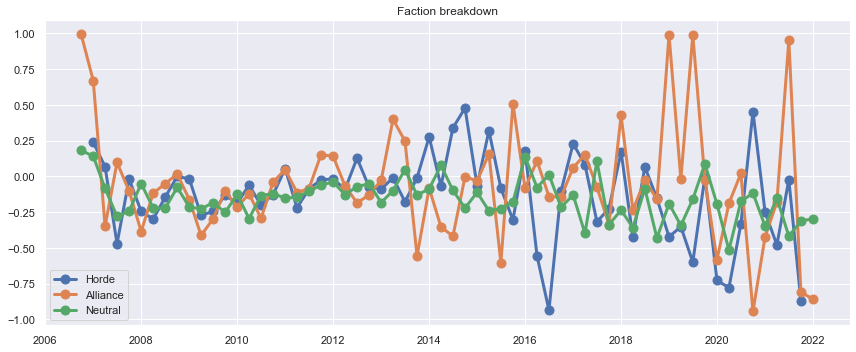

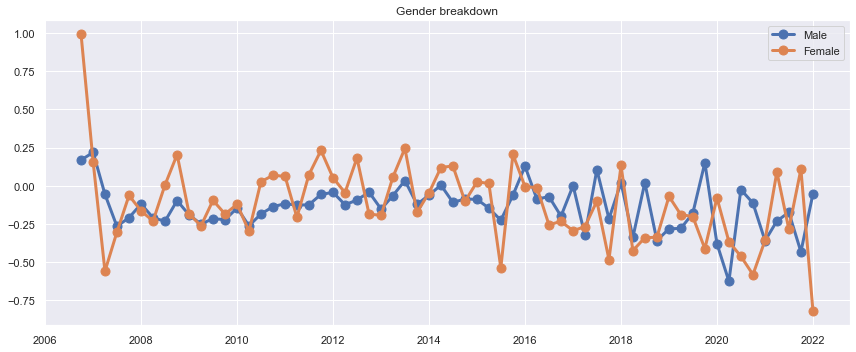

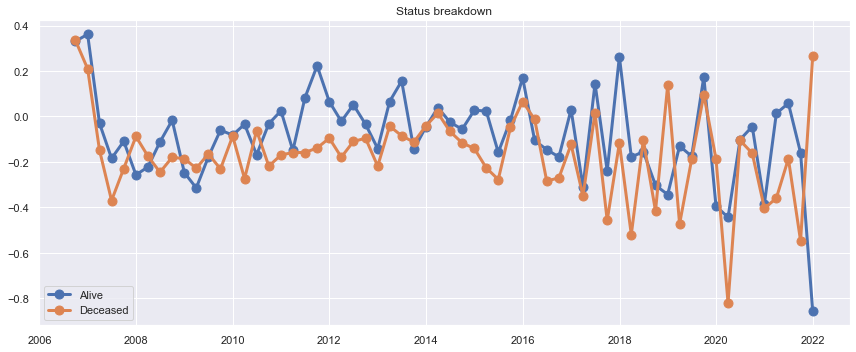

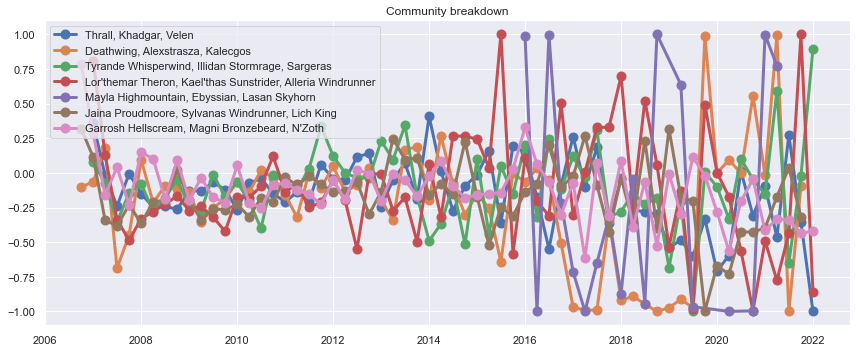

In [317]:
for k,grps in [
    ('Faction', ['Horde', 'Alliance', 'Neutral']),
    ('Gender', ['Male', 'Female']),
    ('Status', ['Alive', 'Deceased']),
    ('Race', )
    ('Community', com_names)
]:
    plt.figure(figsize=(12,5))
    for i,val in enumerate(grps):
        faction_chars = list(df[df[k] == val].Name)

        pairs = []
        for char in faction_chars:
            for comment_id,score in char_sentiments[char]:
                data = char_data[char][comment_id]
                pairs.append(
                    {'date': data['date'], 'score': score}
                )
        d = pd.DataFrame(pairs)
        d = d[d.date > datetime(2006,6,1)]
        d = d[d.date < datetime(2021,11,1)]
        d = d.resample('Q', on='date')
        x = list(d.indices)
        y = d.score.mean().dropna()
        plt.plot(x, y, 'o-', ms=9, linewidth=3, label=val)
    plt.title(k + ' breakdown')
    plt.legend()


    plt.tight_layout()
    plt.show()
    print('\n'*2)

In [322]:
df

,Name,Gender,Race,Faction,Status,Community
0,A'dal,Unknown,Naaru,Neutral,Alive,"Thrall, Khadgar, Velen"
2,Aegwynn,Female,Human,Neutral,Deceased,"Thrall, Khadgar, Velen"
3,Aessina,Female,Wisp,Neutral,Unknown,"Tyrande Whisperwind, Illidan Stormrage, Sargeras"
4,Aethas Sunreaver,Male,Blood Elf,Horde,Alive,"Lor'themar Theron, Kael'thas Sunstrider, Aller..."
5,Agamaggan,Male,Boar,Neutral,Deceased,"Tyrande Whisperwind, Illidan Stormrage, Sargeras"
...,...,...,...,...,...,...
258,Zaetar,Male,Keeper Of The Grove,Neutral,Deceased,"Tyrande Whisperwind, Illidan Stormrage, Sargeras"
259,Zalazane,Male,Jungle Troll,Neutral,Deceased,"Jaina Proudmoore, Sylvanas Windrunner, Lich King"
261,Zul'jin,Male,Forest Troll,Neutral,Deceased,"Lor'themar Theron, Kael'thas Sunstrider, Aller..."
262,Zul,Male,Zandalari Troll,Neutral,Deceased,"Jaina Proudmoore, Sylvanas Windrunner, Lich King"
